## 🔗 You Can Run & Edit This Notebook on Kaggle  
**Link:** [Student Depression Prediction - Kaggle Notebook](https://www.kaggle.com/code/tuhanasinan/student-depression-prediction)


## Installing Required Libraries

In [1]:
!pip install -q catboost


[notice] A new release of pip is available: 24.2 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Importing Necessary Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,StackingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix,RocCurveDisplay,classification_report,roc_curve,confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.simplefilter("ignore")

##

## General Data Overview

In [3]:
df=pd.read_csv("data/student_depression_dataset.csv")
def check_df(dataframe):
    print("################################ Shape ###########################################################")
    print(dataframe.shape)
    print("################################ Types ###########################################################")
    print(dataframe.dtypes)
    print("################################ Missing Values ###########################################################")
    print(dataframe.isnull().sum())

    print("################################ Quantiles ###########################################################")
    print(dataframe.describe([0,0.05,0.50,0.95,0.99,1]).T)


check_df(df)

################################ Shape ###########################################################
(27901, 18)
################################ Types ###########################################################
id                                         int64
Gender                                    object
Age                                      float64
City                                      object
Profession                                object
Academic Pressure                        float64
Work Pressure                            float64
CGPA                                     float64
Study Satisfaction                       float64
Job Satisfaction                         float64
Sleep Duration                            object
Dietary Habits                            object
Degree                                    object
Have you ever had suicidal thoughts ?     object
Work/Study Hours                         float64
Financial Stress                          object
Family

In [4]:
df.describe([0,0.05,0.50,0.95,0.99,1]).T

,count,mean,std,min,0%,5%,50%,95%,99%,100%,max
id,27901.0,70442.149421,40641.175216,2.0,2.0,7158.00,70684.00,133677.00,139299.00,140699.0,140699.0
Age,27901.0,25.822300,4.905687,18.0,18.0,18.00,25.00,34.00,34.00,59.0,59.0
Academic Pressure,27901.0,3.141214,1.381465,0.0,0.0,1.00,3.00,5.00,5.00,5.0,5.0
Work Pressure,27901.0,0.000430,0.043992,0.0,0.0,0.00,0.00,0.00,0.00,5.0,5.0
CGPA,27901.0,7.656104,1.470707,0.0,0.0,5.38,7.77,9.89,9.96,10.0,10.0
Study Satisfaction,27901.0,2.943837,1.361148,0.0,0.0,1.00,3.00,5.00,5.00,5.0,5.0
Job Satisfaction,27901.0,0.000681,0.044394,0.0,0.0,0.00,0.00,0.00,0.00,4.0,4.0
Work/Study Hours,27901.0,7.156984,3.707642,0.0,0.0,0.00,8.00,12.00,12.00,12.0,12.0
Depression,27901.0,0.585499,0.492645,0.0,0.0,0.00,1.00,1.00,1.00,1.0,1.0


###  Dropping the `id` Column

We removed the `id` column as it does not carry any meaningful information.


In [5]:
df.drop("id",axis=1,inplace=True)

## Detection of numeric and categorical variables


In [6]:
def grab_col_names(dataframe, cat_th=10, car_th=20):
   
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    return cat_cols, num_cols, cat_but_car, num_but_cat

cat_cols,num_cols,cat_but_car,num_but_cat=grab_col_names(df)

Observations: 27901
Variables: 17
cat_cols: 12
num_cols: 3
cat_but_car: 2
num_but_cat: 5


In [7]:
num_cols

['Age', 'CGPA', 'Work/Study Hours']

In [8]:
num_but_cat

['Academic Pressure',
 'Work Pressure',
 'Study Satisfaction',
 'Job Satisfaction',
 'Depression']

In [9]:
cat_but_car

['City', 'Degree']

## Analysis of Numerical Variables

count    27901.000000
mean        25.822300
std          4.905687
min         18.000000
5%          18.000000
10%         19.000000
20%         21.000000
30%         23.000000
40%         24.000000
50%         25.000000
60%         28.000000
70%         29.000000
80%         31.000000
90%         33.000000
95%         34.000000
99%         34.000000
max         59.000000
Name: Age, dtype: float64


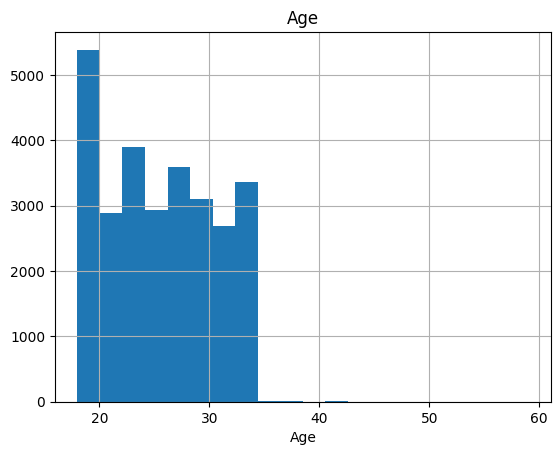

count    27901.000000
mean         7.656104
std          1.470707
min          0.000000
5%           5.380000
10%          5.640000
20%          6.020000
30%          6.750000
40%          7.210000
50%          7.770000
60%          8.170000
70%          8.700000
80%          9.190000
90%          9.690000
95%          9.890000
99%          9.960000
max         10.000000
Name: CGPA, dtype: float64


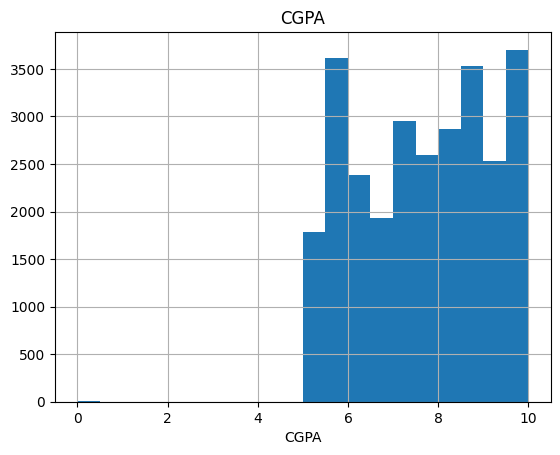

count    27901.000000
mean         7.156984
std          3.707642
min          0.000000
5%           0.000000
10%          1.000000
20%          3.000000
30%          5.000000
40%          7.000000
50%          8.000000
60%          9.000000
70%         10.000000
80%         11.000000
90%         12.000000
95%         12.000000
99%         12.000000
max         12.000000
Name: Work/Study Hours, dtype: float64


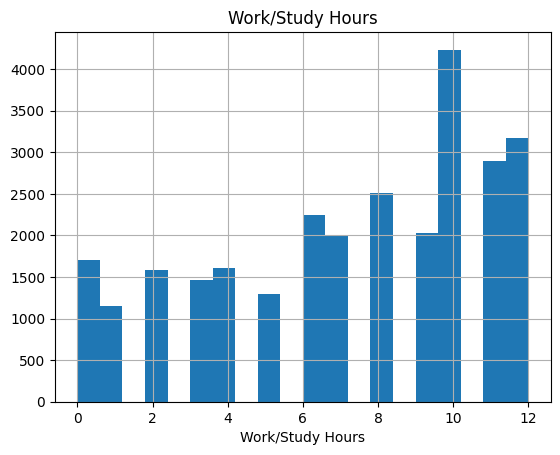

In [10]:
def num_summary(dataframe,numerical_col,plot=False):
    quantiles= [0.05,0.10,0.20,0.30,0.40,0.50,0.60,0.70,0.80,0.90,0.95,0.99]
    print(dataframe[numerical_col].describe(quantiles).T)
    if plot:
        dataframe[numerical_col].hist(bins=20)
        plt.xlabel(numerical_col)
        plt.title(numerical_col)
        plt.show()

for col in num_cols:
    num_summary(df,col,plot=True)

## Analysis of Categorical Variables

Figure saved as categorical_distributions.png


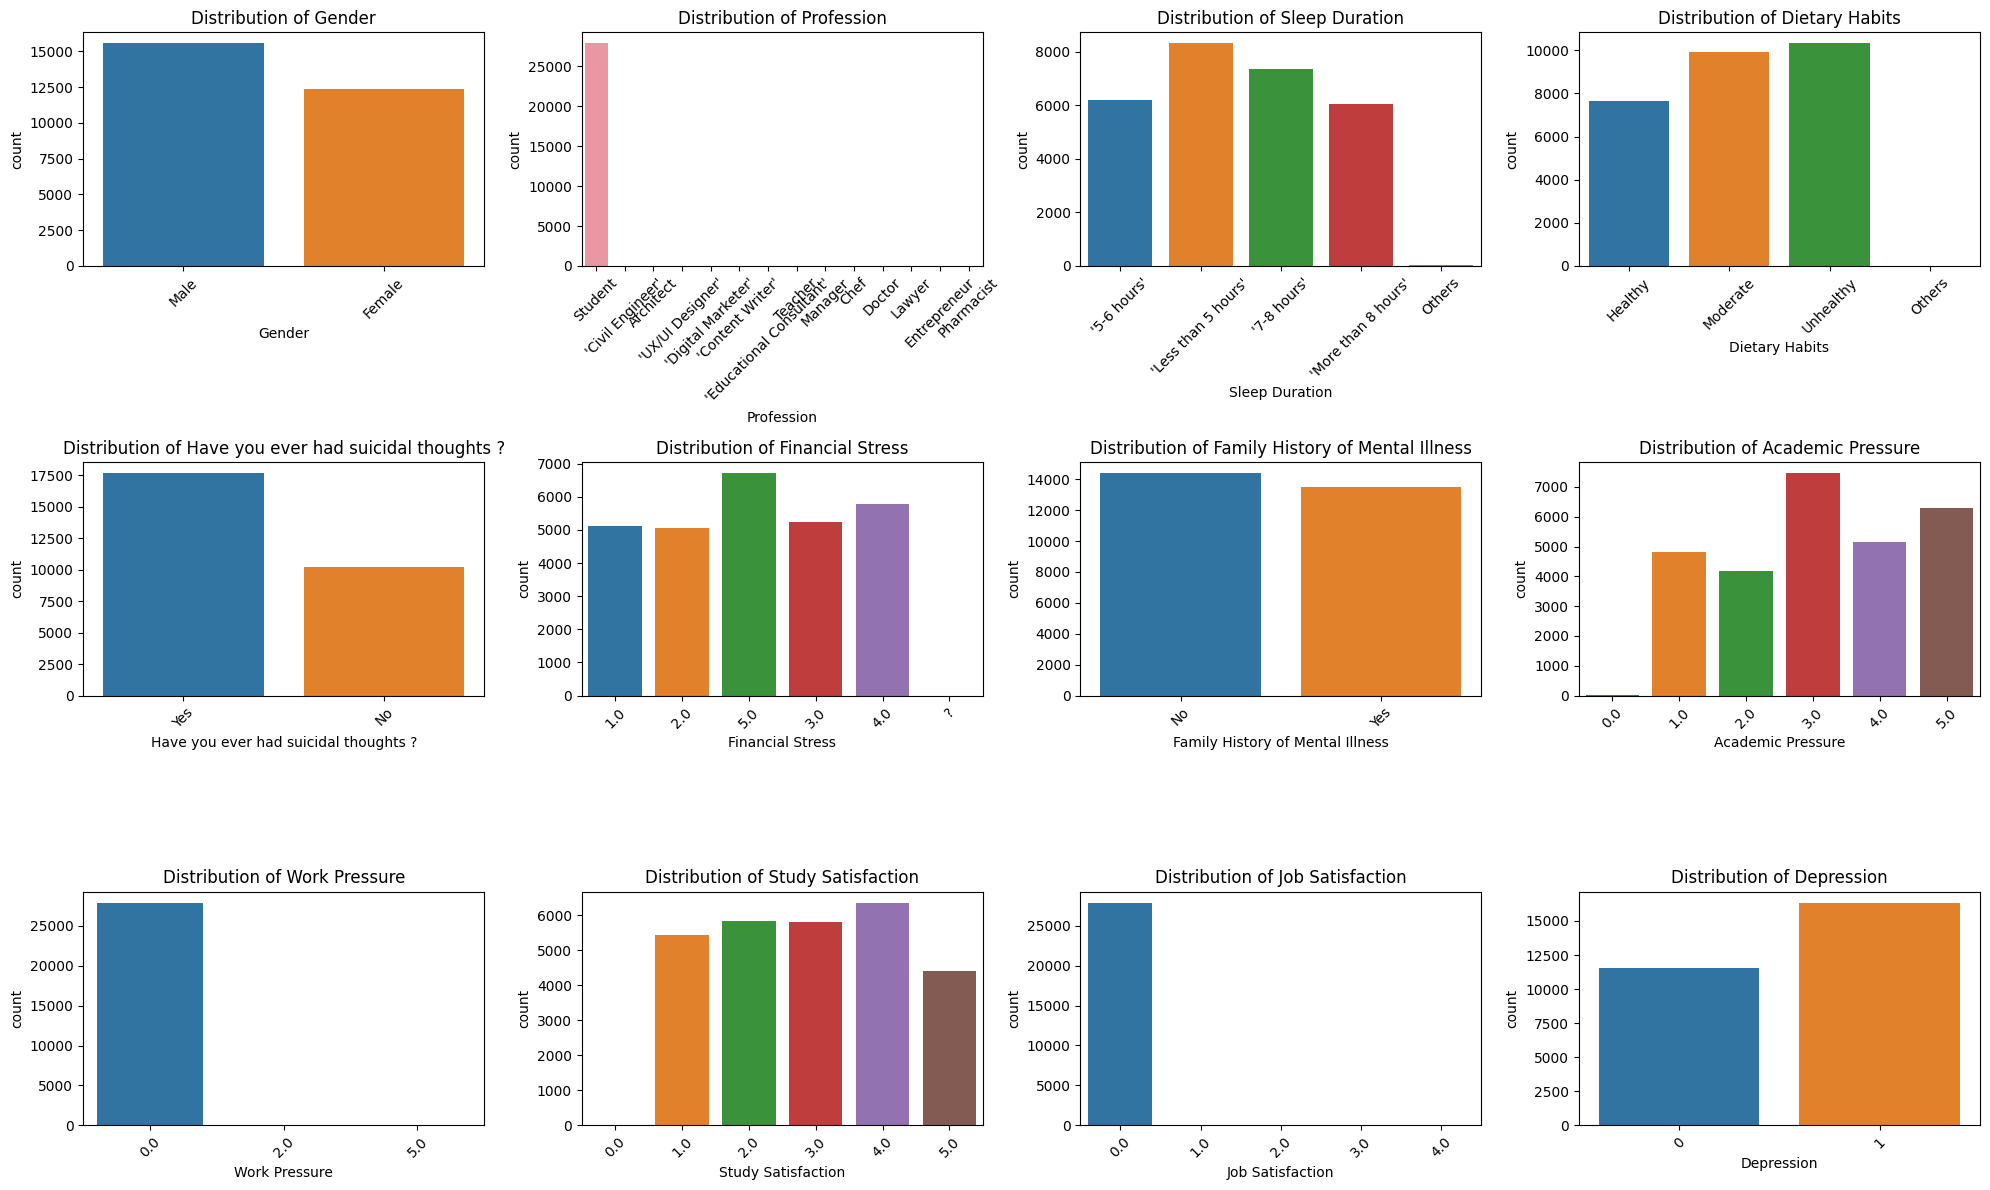

In [11]:

def cat_summary(dataframe, cat_cols, plot=True, save_path=None):
    if plot:
        num_cols = 4  
        num_rows = (len(cat_cols) // num_cols) + (len(cat_cols) % num_cols > 0) 
        
        plt.figure(figsize=(num_cols * 5, num_rows * 4))  
        
        for i, col in enumerate(cat_cols):
            plt.subplot(num_rows, num_cols, i + 1) 
            sns.countplot(x=dataframe[col], data=dataframe)
            plt.title(f'Distribution of {col}')
            plt.xticks(rotation=45)
            
            plt.tight_layout()
        
        if save_path is not None:
            plt.savefig(save_path, dpi=300, bbox_inches='tight')
            print(f"Figure saved as {save_path}")
        
        plt.show()
cat_summary(df, cat_cols=cat_cols, plot=True, save_path="categorical_distributions.png")


Figure saved as categorical_distributions2.png


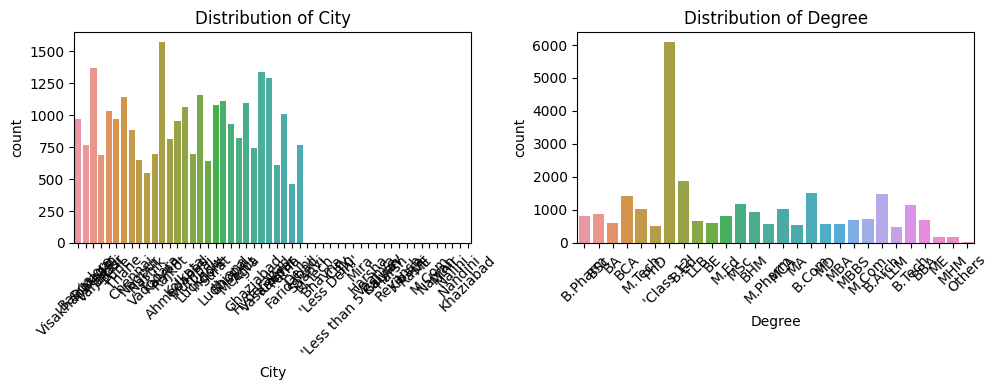

In [12]:
cat_summary(df, cat_cols=cat_but_car, save_path="categorical_distributions2.png")

## Summarizing Numerical and Categorical Variables by Target

In [13]:
def target_summary_with_num(dataframe,col_name,target):
    print(dataframe.groupby(target)[col_name].mean(),end="\n\n\n")
for col in num_cols:
    target_summary_with_num(df,col,"Depression")

Depression
0    27.142412
1    24.887733
Name: Age, dtype: float64


Depression
0    7.617282
1    7.683588
Name: CGPA, dtype: float64


Depression
0    6.237959
1    7.807603
Name: Work/Study Hours, dtype: float64




In [14]:
def target_summary_with_cat(dataframe,target,col_name):
   print( pd.DataFrame({"Target_Mean":dataframe.groupby(col_name)[target].mean()}),end="\n\n\n")
for col in cat_cols:
   target_summary_with_cat(df,"Depression",col)

        Target_Mean
Gender             
Female     0.584507
Male       0.586287


                          Target_Mean
Profession                           
'Civil Engineer'             1.000000
'Content Writer'             1.000000
'Digital Marketer'           0.666667
'Educational Consultant'     1.000000
'UX/UI Designer'             1.000000
Architect                    0.875000
Chef                         1.000000
Doctor                       1.000000
Entrepreneur                 1.000000
Lawyer                       1.000000
Manager                      1.000000
Pharmacist                   1.000000
Student                      0.585145
Teacher                      0.833333


                     Target_Mean
Sleep Duration                  
'5-6 hours'             0.568818
'7-8 hours'             0.595018
'Less than 5 hours'     0.645126
'More than 8 hours'     0.509265
Others                  0.500000


                Target_Mean
Dietary Habits             
Healthy            

## Correlation Matrix

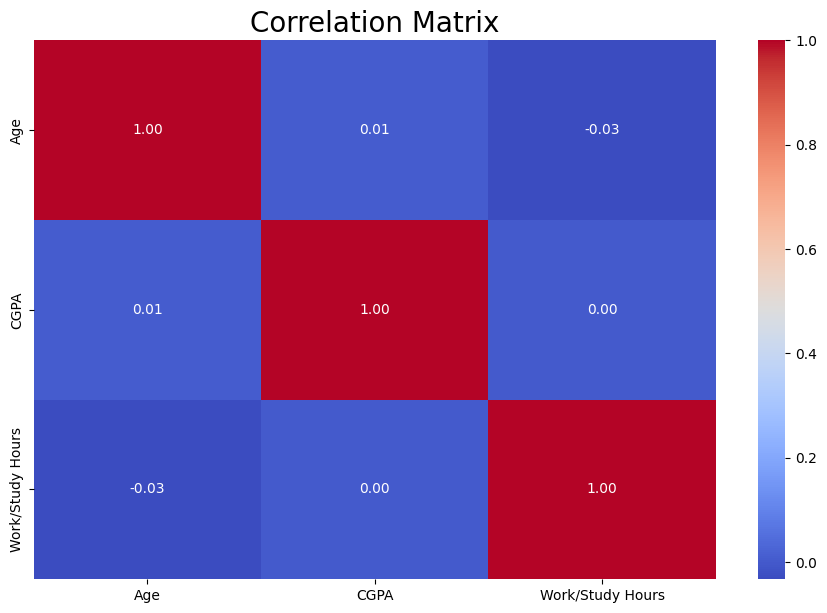

In [15]:
corr = df[num_cols].corr()
f, ax = plt.subplots(figsize=[11,7])
sns.heatmap(corr, annot=True, fmt=".2f", ax=ax, cmap="coolwarm")
ax.set_title("Correlation Matrix", fontsize=20)
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')
plt.show()


In [16]:
plt.savefig("correlation_matrix.png", dpi=300, bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

## Feature Engineering

## Outlier analysis

In [17]:


def outlier_thresholds(dataframe,col_name,q1=0.25,q3=0.75):
    quartile1=dataframe[col_name].quantile(q1)
    quartile3=dataframe[col_name].quantile(q3)
    interquantile_range=quartile3-quartile1
    up_limit= quartile3 + 1.5*interquantile_range
    low_limit=quartile1 - 1.5*interquantile_range
    return low_limit,up_limit

def check_outlier(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    if  dataframe[(dataframe[col_name]<low_limit) | (dataframe[col_name]>up_limit)].any(axis=None):
        return True
    else:
        return False

def replace_with_thresholds(dataframe,col_name):
    low_limit,up_limit=outlier_thresholds(dataframe,col_name)
    dataframe.loc[(dataframe[col_name]< low_limit),col_name]=low_limit
    dataframe.loc[(dataframe[col_name]>up_limit),col_name]=up_limit



for col in num_cols: 
    print(col)

    print(check_outlier(df,col))

Age
True
CGPA
True
Work/Study Hours
False


In [18]:
for col in num_cols:
    replace_with_thresholds(df,col)

for col in num_cols:
    print(check_outlier(df,col))

False
False
False


## Scaling Numerical Features

In [19]:

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()



df[num_cols] = scaler.fit_transform(df[num_cols])

##  One-hot encoding

In [20]:
cat_cols= [col for col in cat_cols if col != "Depression"]

def one_hot_encoder(dataframe, categorical_col, drop_first=False):
    dataframe = pd.get_dummies(data=dataframe, columns=categorical_col, drop_first=drop_first, dtype=int)
    return dataframe

df = one_hot_encoder(df, cat_cols)
df= one_hot_encoder(df, cat_but_car)

## Model Building

In [21]:

X = df.drop("Depression", axis=1)
y = df["Depression"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12345)


models = [
    ("LR", LogisticRegression(random_state=12345)),
    ("KNN", KNeighborsClassifier()),
    ("CART", DecisionTreeClassifier(random_state=12345)),
    ("RF", RandomForestClassifier()),
    ("SVM", SVC(gamma="auto", probability=True, random_state=12345)),
    ("XGB", XGBClassifier(random_state=12345)),
    ("LGM", LGBMClassifier(random_state=12345)),
    ("CatBoost", CatBoostClassifier(verbose=False, random_state=12345))
]


models_results = pd.DataFrame(columns=['Model', "Accuracy", 'F1', 'Precision', 'Recall', 'ROC AUC'])


for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    
    print(f"########## Model: {name} #########")
    print(classification_report(y_test, y_pred))
    
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X_test)[:, 1]
        roc_auc = roc_auc_score(y_test, y_prob)
    else:
        roc_auc = "N/A"
    
    models_results.loc[len(models_results)] = [name, accuracy, f1, precision, recall, roc_auc]



########## Model: LR #########
              precision    recall  f1-score   support

           0       0.84      0.79      0.82      2314
           1       0.86      0.90      0.88      3267

    accuracy                           0.85      5581
   macro avg       0.85      0.84      0.85      5581
weighted avg       0.85      0.85      0.85      5581

########## Model: KNN #########
              precision    recall  f1-score   support

           0       0.82      0.72      0.76      2314
           1       0.81      0.89      0.85      3267

    accuracy                           0.82      5581
   macro avg       0.82      0.80      0.81      5581
weighted avg       0.82      0.82      0.81      5581

########## Model: CART #########
              precision    recall  f1-score   support

           0       0.73      0.72      0.72      2314
           1       0.80      0.81      0.81      3267

    accuracy                           0.77      5581
   macro avg       0.76      0.7

In [22]:
models_results

,Model,Accuracy,F1,Precision,Recall,ROC AUC
0,LR,0.852356,0.851528,0.852011,0.852356,0.922987
1,KNN,0.815266,0.813065,0.815338,0.815266,0.869640
2,CART,0.771009,0.770831,0.770682,0.771009,0.763375
3,RF,0.842501,0.841570,0.842058,0.842501,0.914276
4,SVM,0.850206,0.849365,0.849833,0.850206,0.921955
5,XGB,0.841426,0.840852,0.840868,0.841426,0.915812
6,LGM,0.851639,0.851085,0.851164,0.851639,0.921543
7,CatBoost,0.853431,0.852707,0.853032,0.853431,0.922933


## Building a Deep Learning Neural Network Model

In [23]:

model = Sequential([
    Dense(512, input_shape=(X_train.shape[1],), activation="relu"),
    Dropout(0.2),
    Dense(256, activation="relu"),
    Dropout(0.2),
    Dense(64, activation="relu"),
    Dense(1, activation="sigmoid") 
])

model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

es = EarlyStopping(monitor="val_loss", mode="min", patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, validation_data=(X_test, y_test),
                    callbacks=[es], epochs=50, batch_size=32, verbose=1)


Epoch 1/50


2025-05-23 21:42:19.568493: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


698/698 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.8132 - loss: 0.4086 - val_accuracy: 0.8500 - val_loss: 0.3706
Epoch 2/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8419 - loss: 0.3613 - val_accuracy: 0.8466 - val_loss: 0.3617
Epoch 3/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8493 - loss: 0.3508 - val_accuracy: 0.8502 - val_loss: 0.3490
Epoch 4/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8486 - loss: 0.3457 - val_accuracy: 0.8479 - val_loss: 0.3587
Epoch 5/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8523 - loss: 0.3397 - val_accuracy: 0.8479 - val_loss: 0.3536
Epoch 6/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8586 - loss: 0.3260 - val_accuracy: 0.8466 - val_loss: 0.3605
Epoch 7/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8673 - loss: 0.3096 - val_accuracy: 0.8470 - val_loss: 0.3670
Epoch 8/50
698/698 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.8704 - loss: 0.2911 - val_accuracy: 0.8343 - val_

In [24]:
y_prob = model.predict(X_test)


y_pred = (y_prob > 0.5).astype(int)


accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
roc_auc = roc_auc_score(y_test, y_prob)


print("\n########## Model: Deep Learning ##########")
print(f"Accuracy   : {accuracy:.6f}")
print(f"Precision  : {precision:.6f}")
print(f"Recall     : {recall:.6f}")
print(f"F1 Score   : {f1:.6f}")
print(f"ROC AUC    : {roc_auc:.6f}")
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred))

175/175 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

########## Model: Deep Learning ##########
Accuracy   : 0.850206
Precision  : 0.850423
Recall     : 0.850206
F1 Score   : 0.848879
ROC AUC    : 0.922404

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      2314
           1       0.85      0.91      0.88      3267

    accuracy                           0.85      5581
   macro avg       0.85      0.84      0.84      5581
weighted avg       0.85      0.85      0.85      5581



## Ensemble Modeling with Stacking Classifier

In [25]:
stacking_clf = StackingClassifier(
    estimators=[
          ('cat', CatBoostClassifier(verbose=False,random_state=12345)),
       ('xgb', XGBClassifier(random_state=12345)),
        ('lgbm', LGBMClassifier(random_state=12345)),
        
    ],
    final_estimator= LogisticRegression(random_state=12345),
    cv=5
)

stacking_clf.fit(X_train, y_train)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 13069, number of negative: 9251
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000590 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 452
[LightGBM] [Info] Number of data points in the train set: 22320, number of used features: 90
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.585529 -> initscore=0.345511
[LightGBM] [Info] Start training from score 0.345511
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 10455, number of negative: 7401
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000470 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wi

StackingClassifier(cv=5,
                   estimators=[('cat',
                                <catboost.core.CatBoostClassifier object at 0x7d13382d7310>),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric=None,
                                              feature_types=None, gamma=None,
                                              grow_p...
                                              max_cat_threshold=None,
                                              max_cat_to_onehot=None,
                                              max_delta_step=None,
                                              max_depth=None, max_leaves=None,
                                              min_child_weight=None,
                                              missing=nan,
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None,
                                              random_state=12345, ...)),
                               ('lgbm', LGBMClassifier(random_state=12345))],
                   final_estimator=LogisticRegression(random_state=12345))

In [26]:
def evaluate_model(model, X_test, y_test, name="Model"):
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)

    if hasattr(model, "predict_proba"):
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            roc_auc = roc_auc_score(y_test, y_prob)
        except:
            roc_auc = "ROC AUC could not be calculated (no probabilities or error)"
    else:
        roc_auc = "ROC AUC could not be calculated (predict_proba not available)"

    print(f"\n########## Model: {name} ##########")
    print(f"Accuracy   : {accuracy:}")
    print(f"Precision  : {precision:}")
    print(f"Recall     : {recall:}")
    print(f"F1 Score   : {f1:}")
    print(f"ROC AUC    : {roc_auc if isinstance(roc_auc, str) else f'{roc_auc:}'}\n")
    print("Classification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))


In [27]:
evaluate_model(stacking_clf,X_test, y_test)


########## Model: Model ##########
Accuracy   : 0.8557606163769934
Precision  : 0.855434089812299
Recall     : 0.8557606163769934
F1 Score   : 0.8549815446172118
ROC AUC    : 0.922995704405306

Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.79      0.82      2314
           1       0.86      0.90      0.88      3267

    accuracy                           0.86      5581
   macro avg       0.85      0.85      0.85      5581
weighted avg       0.86      0.86      0.85      5581



## ROC  Curve

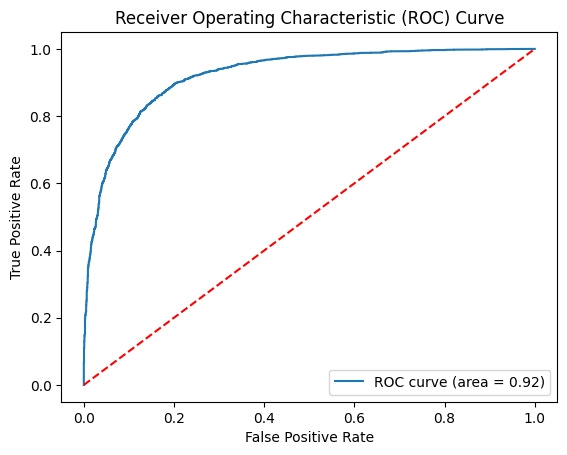

In [28]:

from sklearn.metrics import roc_curve, roc_auc_score

def generate_auc_roc_curve(clf, X_test, y_test, filename="roc_auc_curve.png"):
    y_pred_proba = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {auc:.2f})')
    plt.plot([0, 1], [0, 1], linestyle='--', color='r')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    
    
    plt.savefig(filename)
    plt.show()


generate_auc_roc_curve(stacking_clf, X_test, y_test, filename="stacking_roc_auc.png")



##  Confusion Matrix

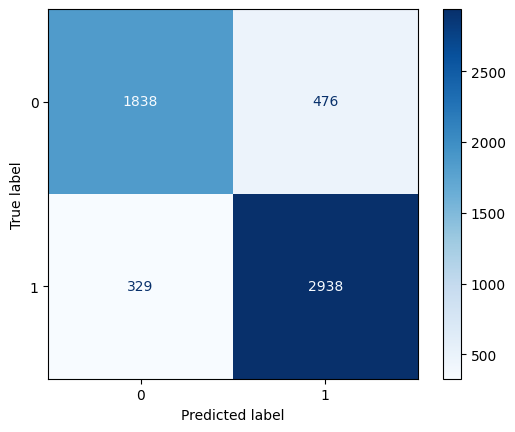

In [29]:

y_pred = stacking_clf.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)

plt.savefig("stacking_confusion_matrix.png")  # Grafik dosyasını kaydet
plt.show()


## Feature Importances

Feature importances for: LR


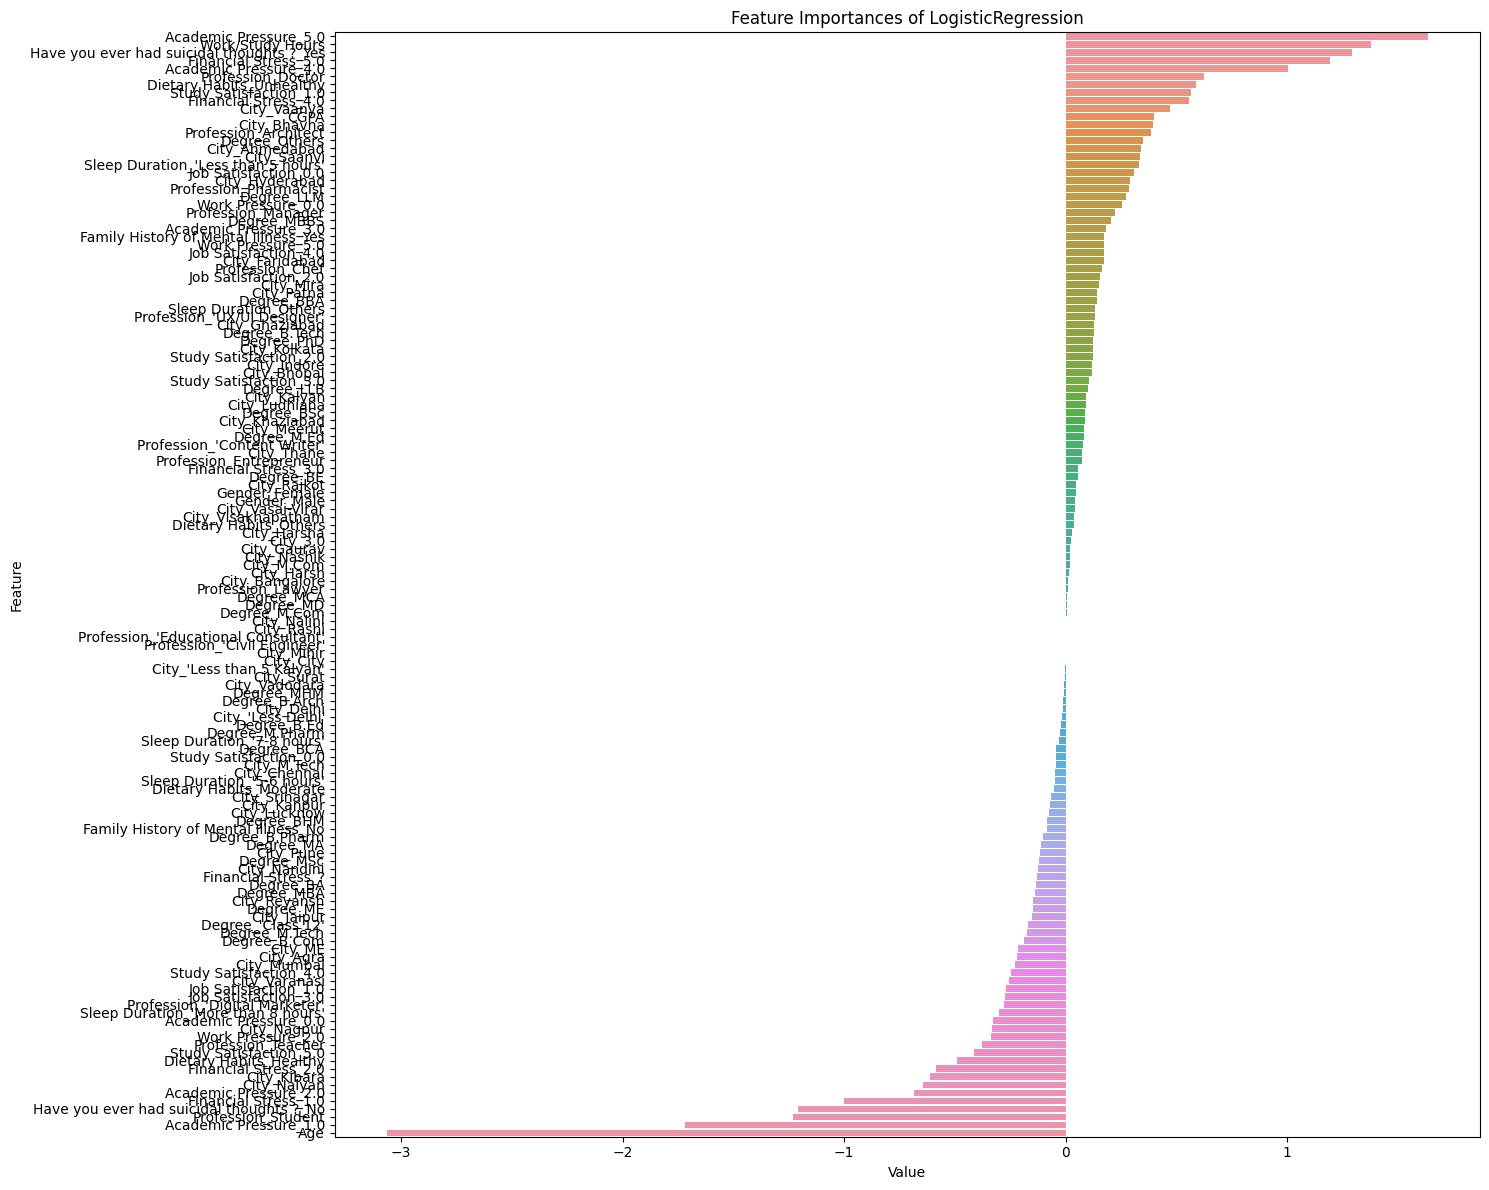

Feature importances for: KNN
Could not plot importances for KNN: The model does not have feature importances or coefficients.
Feature importances for: CART


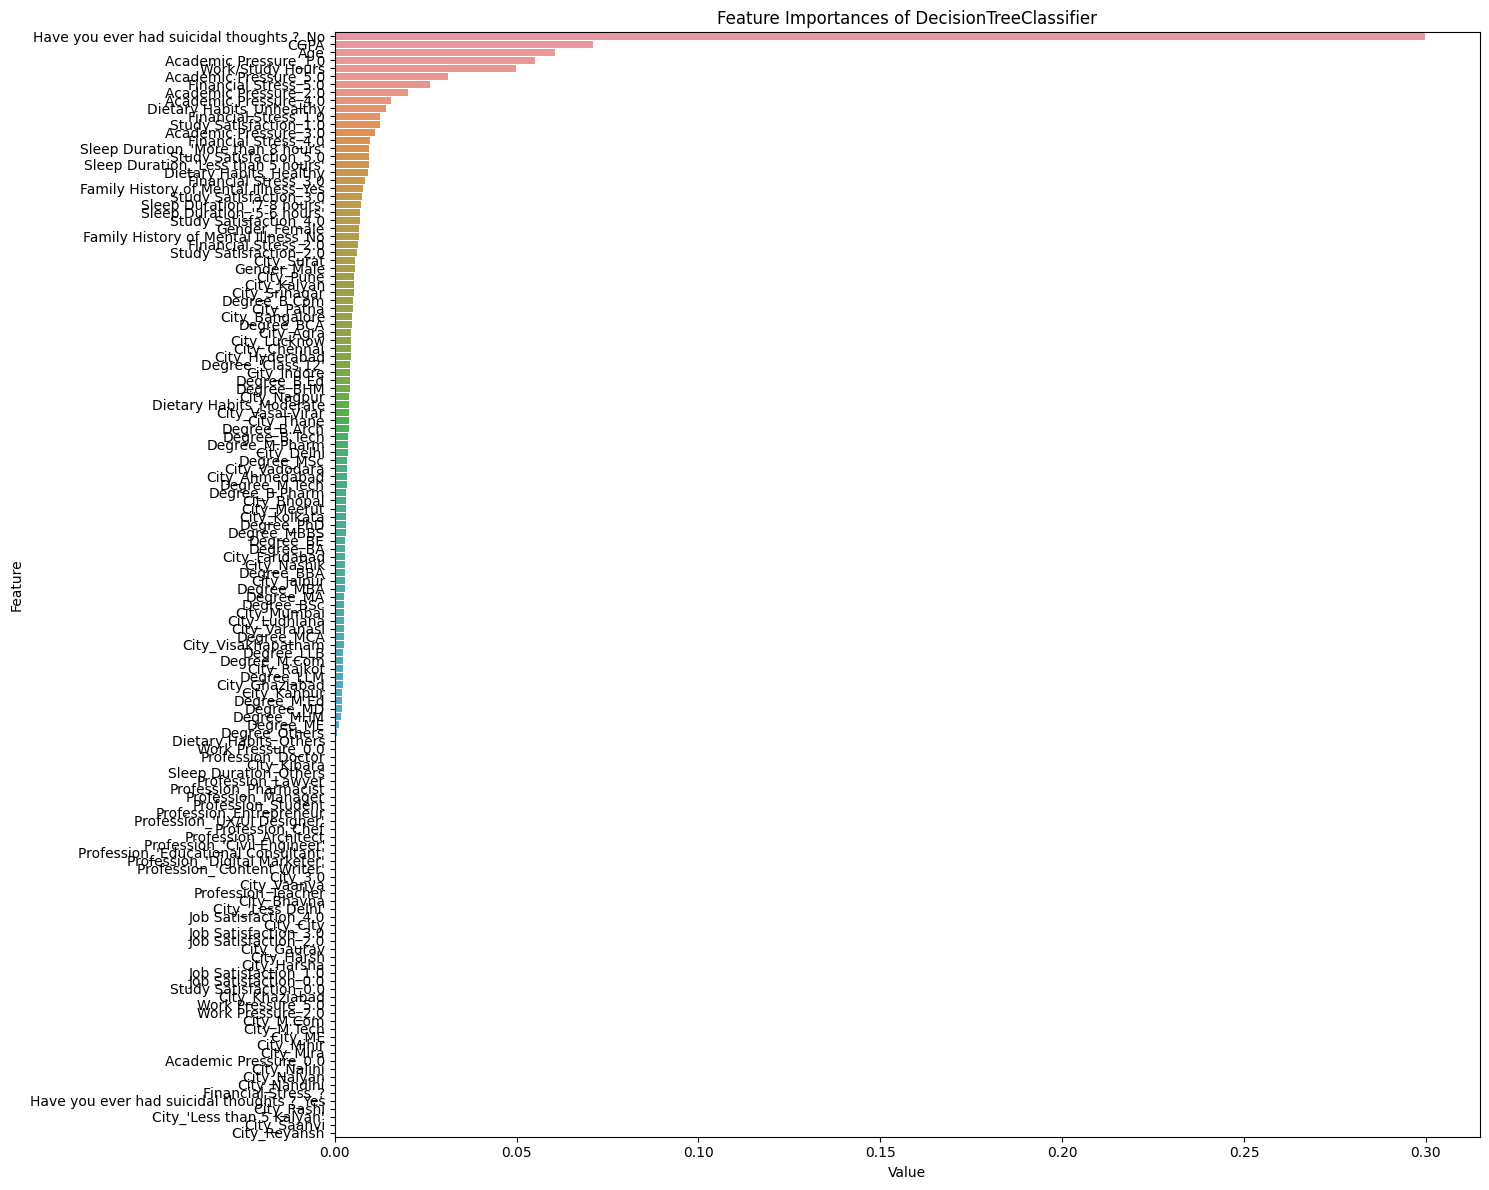

Feature importances for: RF


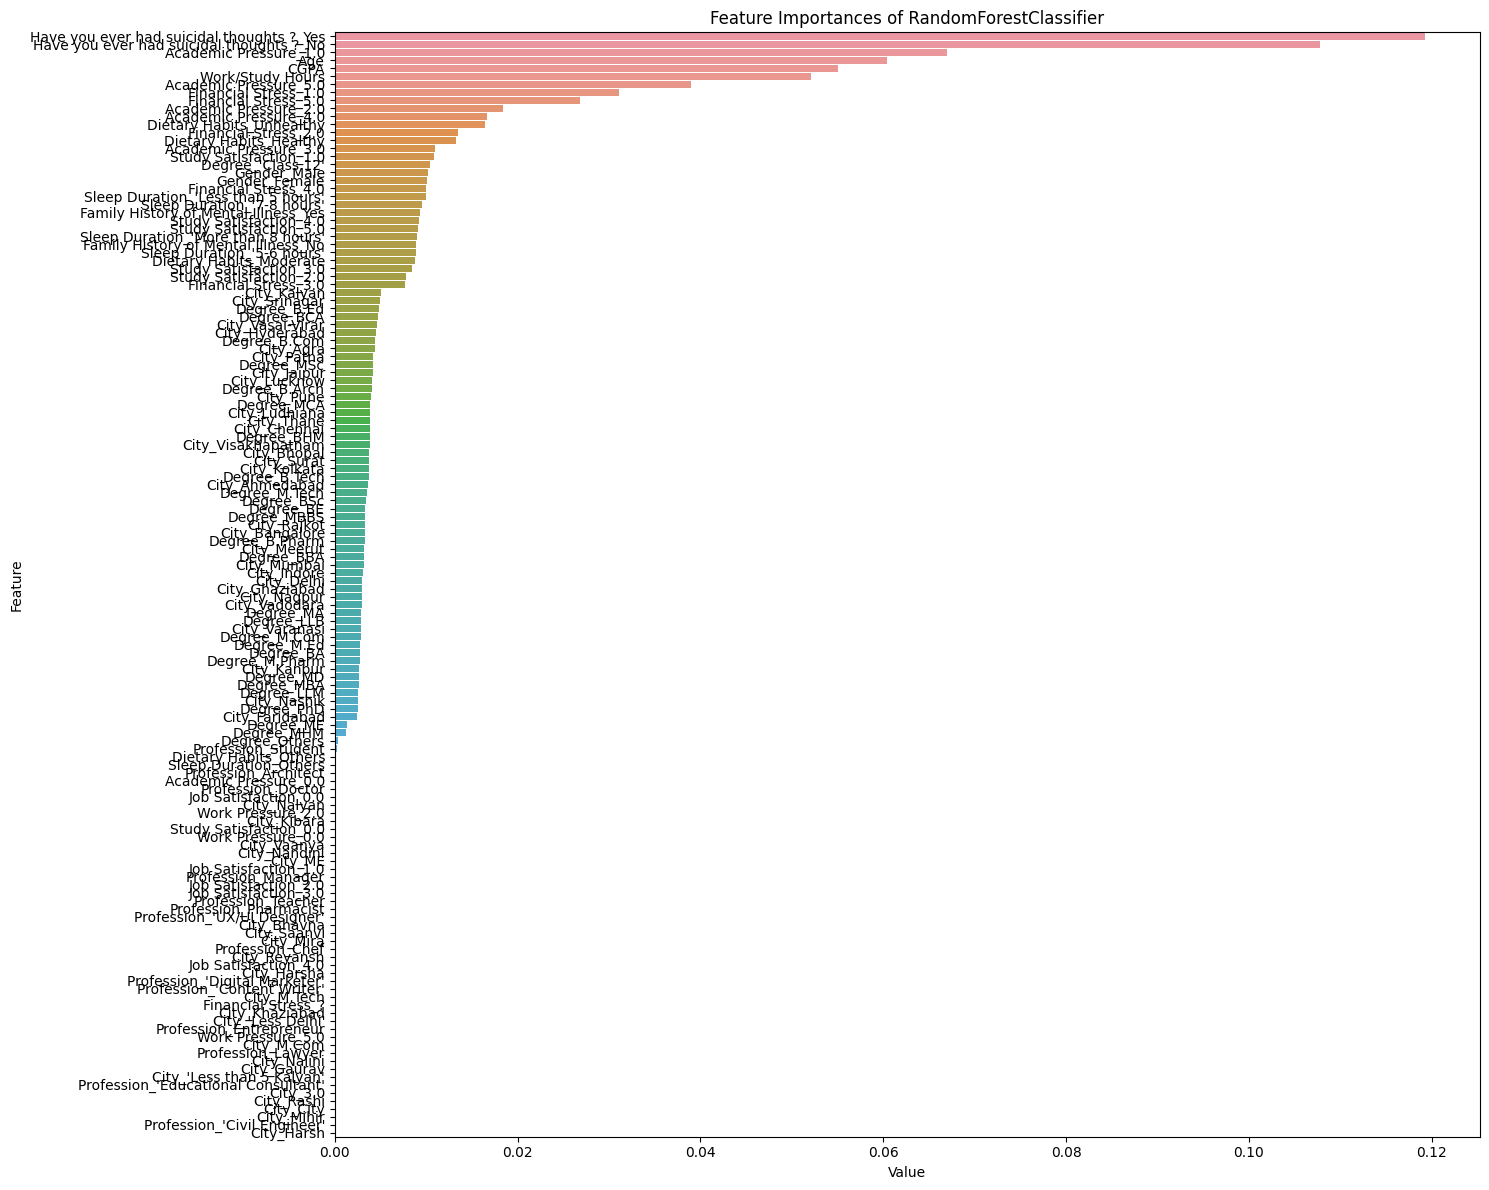

Feature importances for: SVM
Could not plot importances for SVM: The model does not have feature importances or coefficients.
Feature importances for: XGB


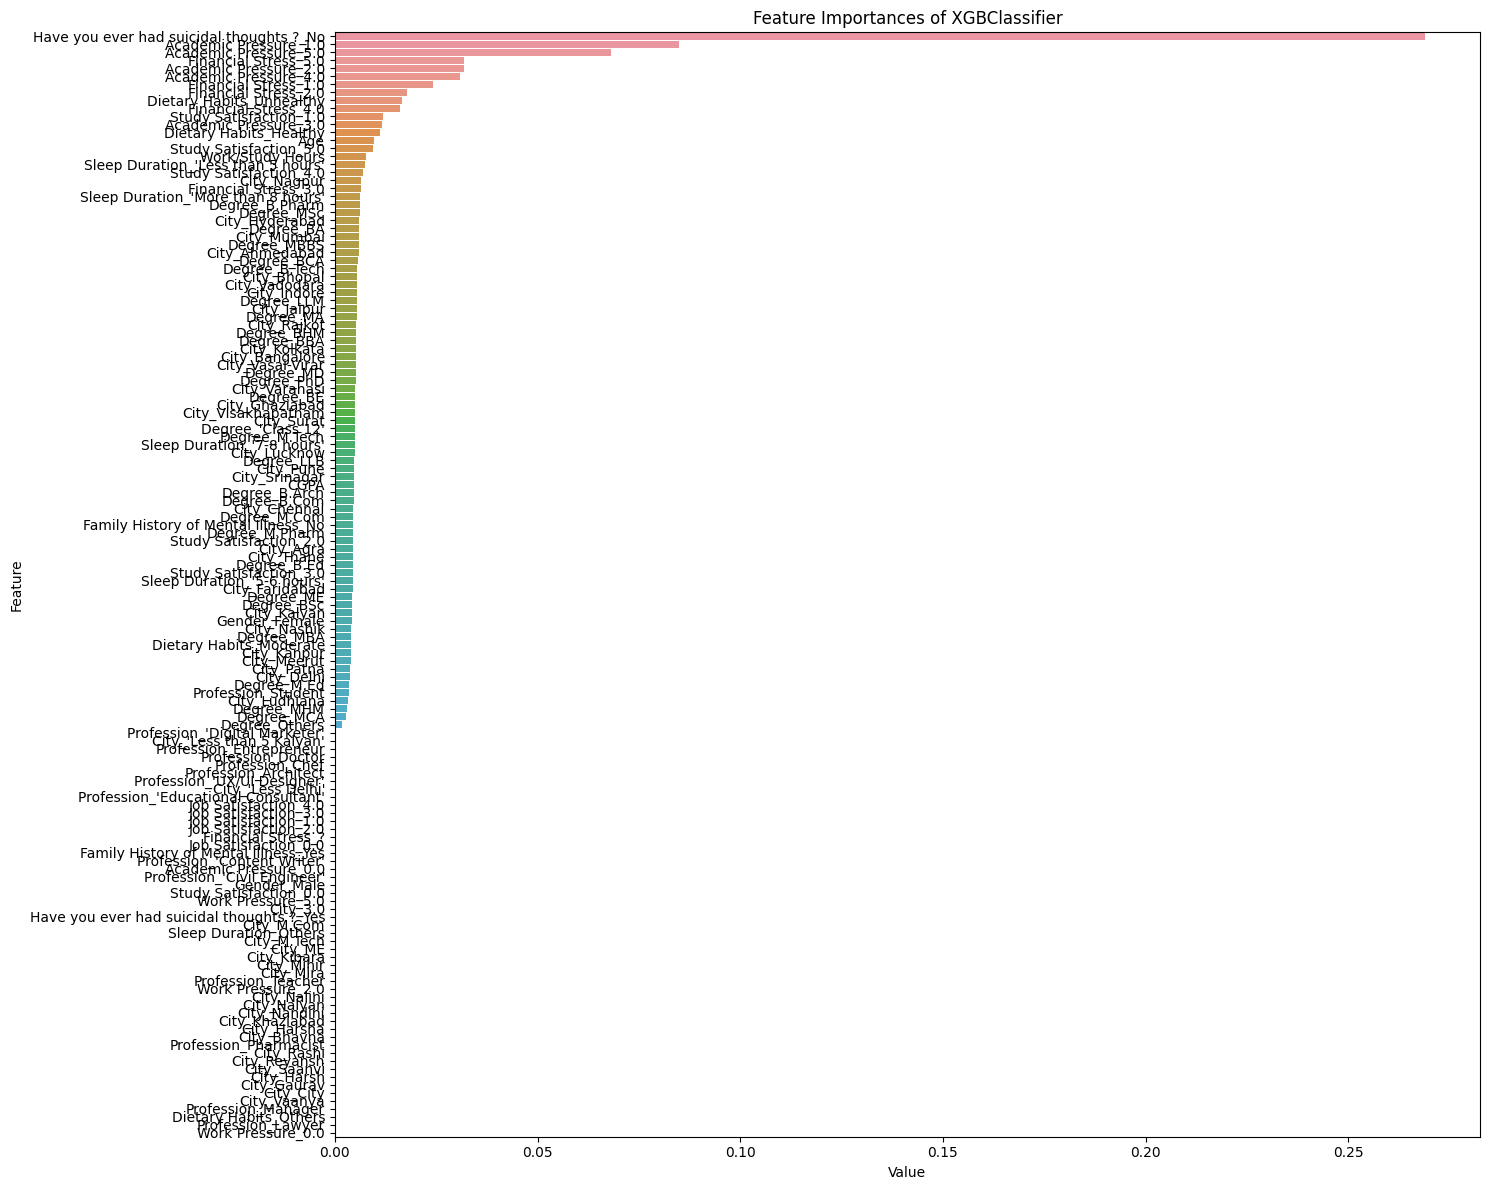

Feature importances for: LGM


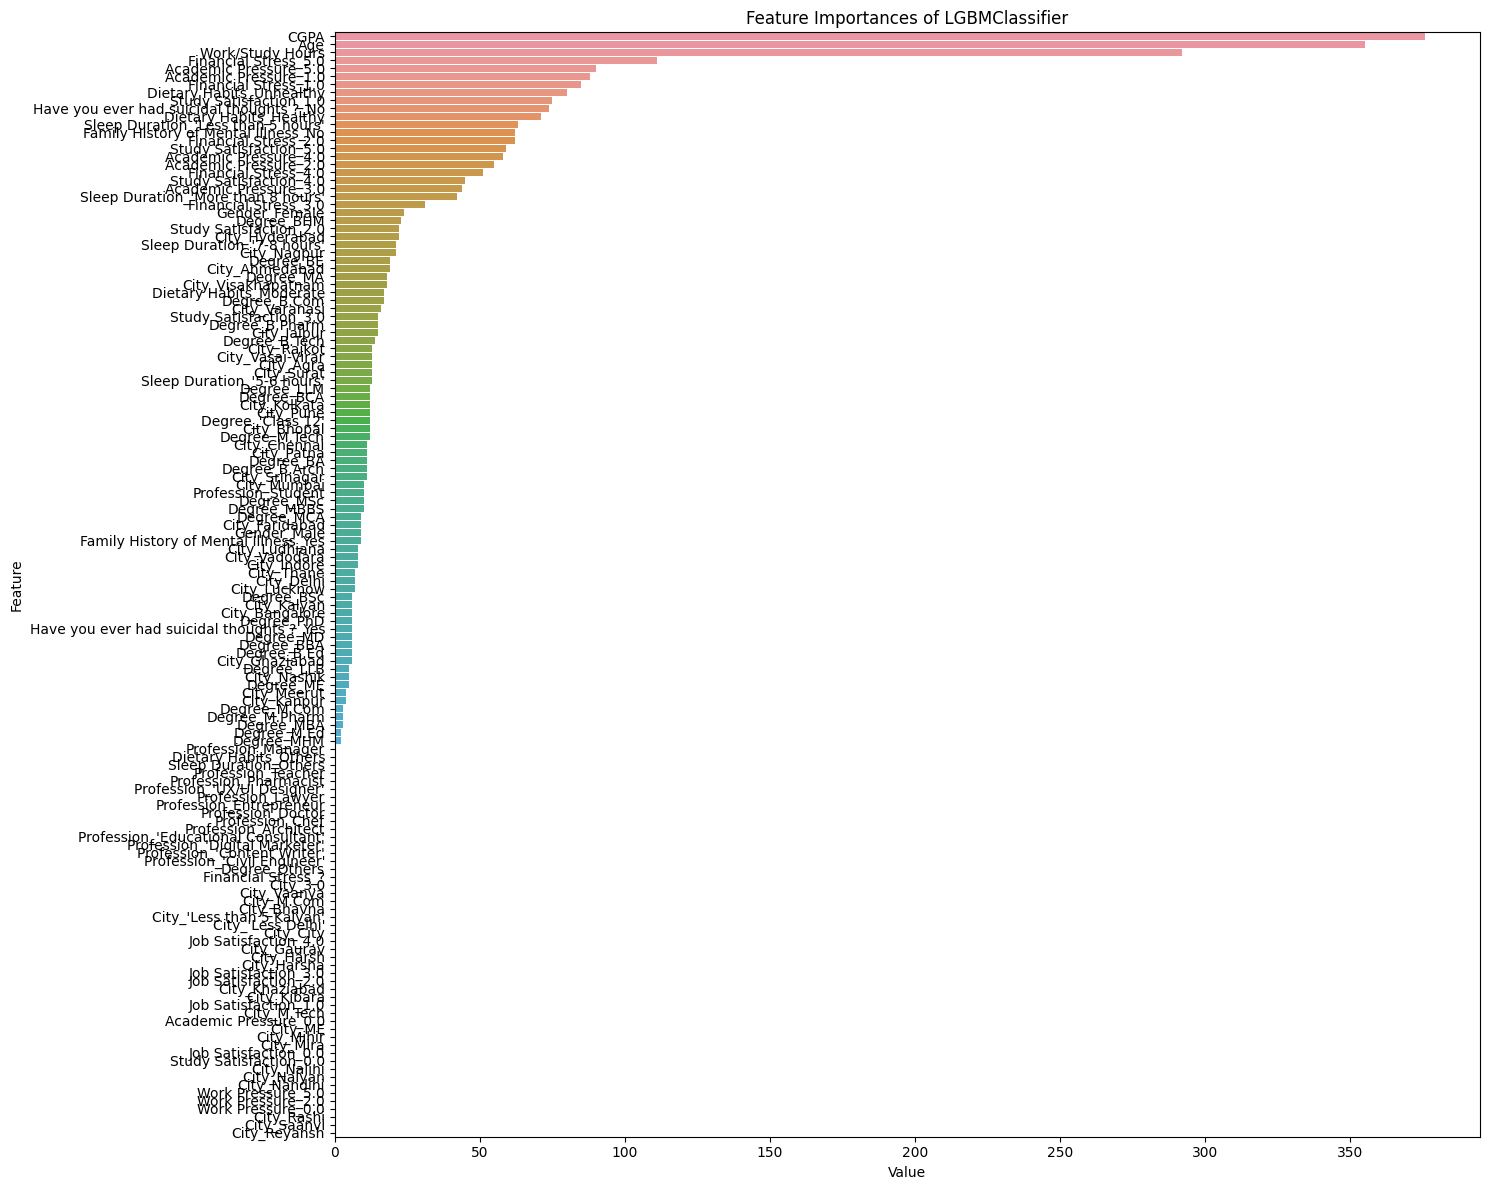

Feature importances for: CatBoost


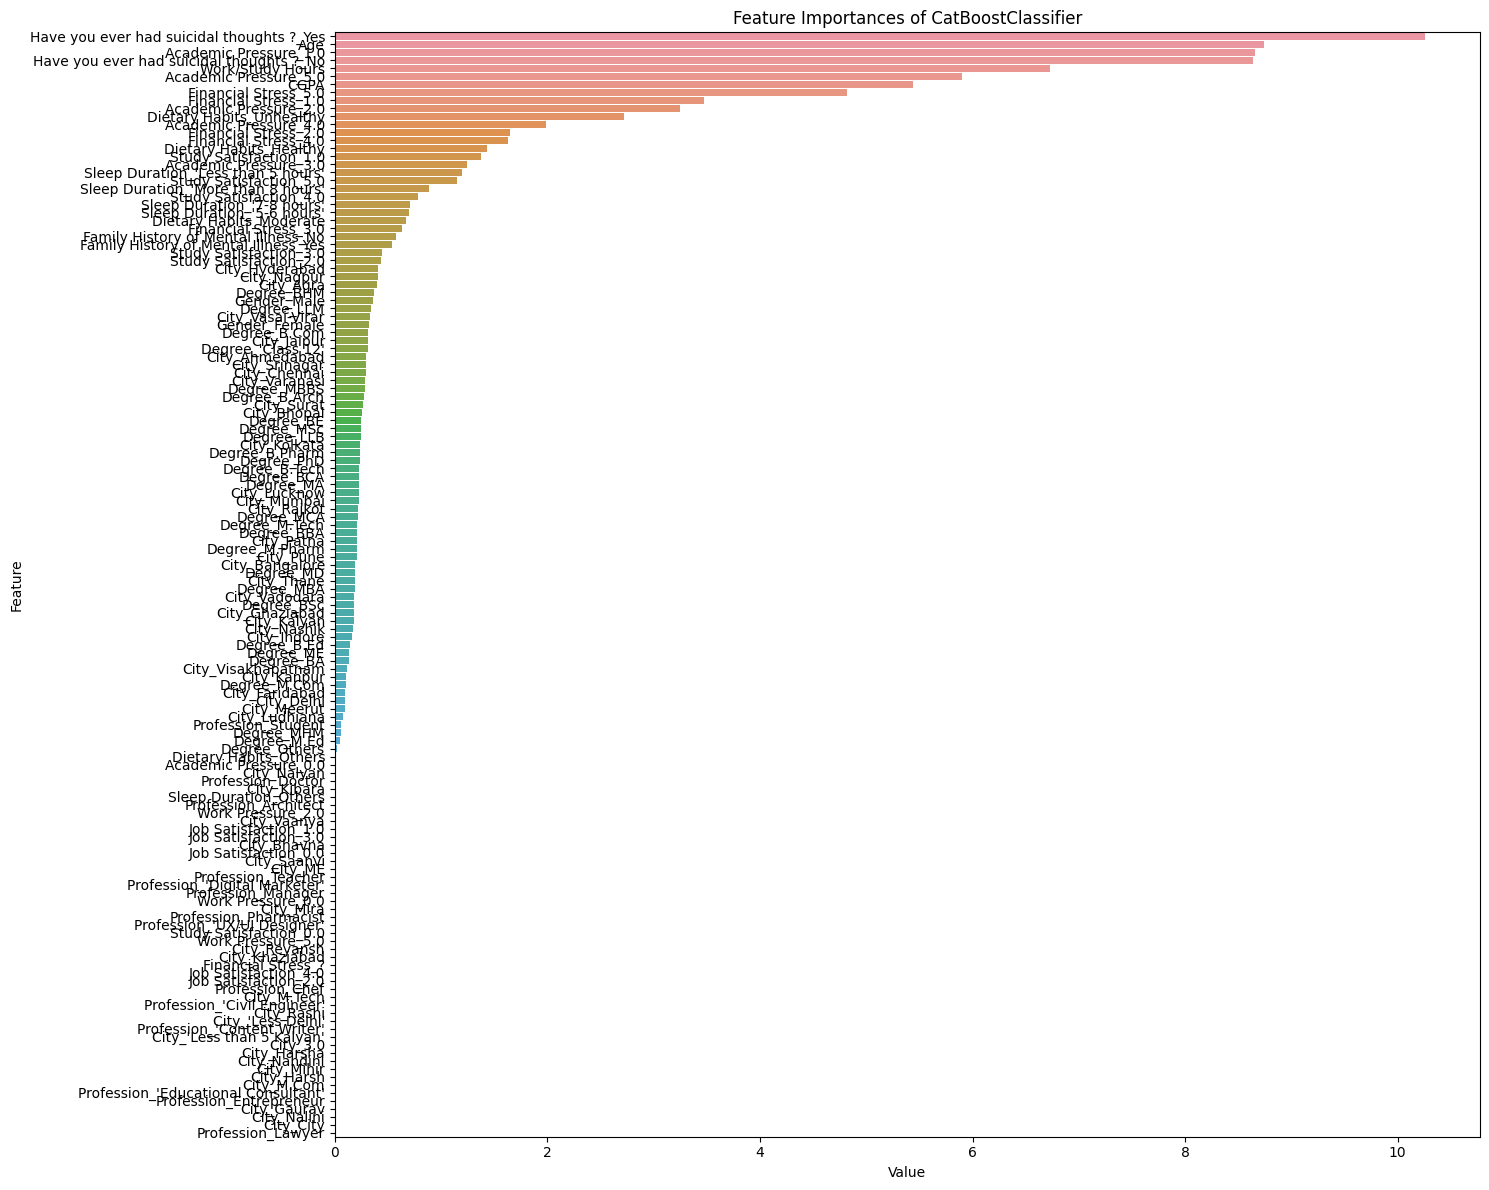

In [31]:
def plot_importances(model, features, num=None, save=False):
    if num is None:
        num = len(features.columns)

  
    if hasattr(model, 'feature_importances_'):
        feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    elif hasattr(model, 'coef_'):
        feature_imp = pd.DataFrame({"Value": model.coef_[0], "Feature": features.columns})
    else:
        raise ValueError("The model does not have feature importances or coefficients.")
    
    plt.figure(figsize=(15, 12))
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).head(num))
    plt.title(f'Feature Importances of {type(model).__name__}')
    plt.tight_layout()
    
    if save:
        plt.savefig('feature_importances.png')
    
    plt.show()
    models = [
    ("catboost", stacking_clf.named_estimators_['cat']),
    ("xgboost", stacking_clf.named_estimators_['xgb']),
    ("lightgbm", stacking_clf.named_estimators_['lgbm']),
    ("final_estimator", stacking_clf.final_estimator_)
]

for name, model in models:
    print(f"Feature importances for: {name}")
    try:
        if name == "final_estimator":
            features = pd.DataFrame(columns=["cat", "xgb", "lgbm"])
        else:
            features = X_train
        plot_importances(model, features)
    except ValueError as e:
        print(f"Could not plot importances for {name}: {e}")

